# Modeling

Mỗi cá thể được biểu diễn dưới dạng mảng 1 chiều:
- $[x_1, x_2, \dots, x_n]$, trong đó n là số lượng sensors
- $x_i \in [0, q]$: sensor thứ i được kích hoạt và đang hướng về phía $x_i$
- $x_i = q$: sensor thứ i không được kích hoạt

Phép lai ghép:
- Chọn 2 cá thể $X_A$ và $X_B$ trong tập tốt nhất (60% quần thể)
- Sinh ra cá thể mới X bằng cách:
    - Với mỗi sensor, sinh 1 số ngẫu nhiên rand
    - $X[i] = X_A[i] ~ if ~ rand ~ < 0.5 $
    - $X[i] = X_B[i] ~ if ~ rand ~ \ge 0.5$

Phép đột biến:
- Chọn ngẫu nhiên một vài (ít) cá thể X_t
- Chọn ngẫu nhiên 1 sensor (tức $x_i \in X_t$)
- Thay đổi ngẫu nhiên giá trị $x_i$

# Implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as ptc
import typing
import tqdm
import pickle

In [ ]:
np.random.seed(42)

In [ ]:
class Config(typing.NamedTuple):
    pop_size: int
    temperature: float
    threshold: float
    useless_penalty: float
    active_penalty: float


In [ ]:
!gdown 1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
!gdown 1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE

Downloading...
From: https://drive.google.com/uc?id=1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
To: /content/fix_targets.pkl
100% 4.21M/4.21M [00:00<00:00, 229MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE
To: /content/fix_sensors.pkl
100% 4.45M/4.45M [00:00<00:00, 154MB/s]


In [ ]:
with open("/content/fix_sensors.pkl", 'rb') as f:
  fs_data = pickle.load(f)

with open("/content/fix_targets.pkl", 'rb') as f:
  ft_data = pickle.load(f)


In [ ]:
def make_pan_boundaries(centroid, q, radius):
    # first line always lies on x_axis
    ans = []
    theta = 2*np.pi/q
    for i in range(q):
        x = radius*np.cos(theta*i)
        y = radius*np.sin(theta*i)
        ans.append((centroid[0] + x, centroid[1] + y))

    return ans

In [ ]:
def show_network(network, sensors_mask=None, figsize=None):
    n = network['n']
    m = network['m']
    q = network['q']

    if figsize is not None:
      plt.figure(figsize=(figsize, figsize))

    margin = network['margin']

    targets = network['targets']
    sensors = network['sensors']
    radius = network['radius']

    tar_x = [i[0] for i in targets]
    tar_y = [i[1] for i in targets]
    plt.plot(tar_x, tar_y, 'r^', label='targets')
    sen_x = [i[0] for i in sensors]
    sen_y = [i[1] for i in sensors]
    plt.plot(sen_x, sen_y, 'go', label='sensors')
    ax = plt.gca()

    for i in range(len(sensors)):
        sensor = sensors[i]
        active = True

        if sensors_mask is not None:
            active = False
            if sensors_mask[i] != q:
                theta = 360.0/q
                dir = sensors_mask[i]
                active = True
                theta1, theta2 = theta*dir, theta*(dir+1)
                wedge = ptc.Wedge(sensors[i], radius, theta1, theta2, color='#34e1eb', alpha=0.45)
                ax.add_artist(wedge)
        if active:
            circle = plt.Circle(sensor, radius, color='m', fill=False, linewidth=1)
            ax.add_artist(circle)
            pan_boundaries = make_pan_boundaries(sensor, q, radius)
            for point in pan_boundaries:
                plt.plot([sensor[0], point[0]], [sensor[1], point[1]], 'b--', alpha=0.2)

    plt.xlim(margin[0])
    plt.ylim(margin[1])
    ax.set_aspect(1.0)  # make aspect ratio square

    plt.legend()

    plt.show()

In [ ]:
N_SENSORS = 25
N_TARGETS = 10
network = example_data(N_SENSORS, N_TARGETS)


NameError: ignored

In [ ]:
show_network(network, figsize=10)

NameError: ignored

In [ ]:
def is_within_FoV(bisector, target, sensor, radius):
    target = np.asarray(target)
    sensor = np.asarray(sensor)
    bisector = np.asarray(bisector)
    v = target - sensor
    dist = np.linalg.norm(v)
    scalar = bisector.dot(v)
    return scalar + 1e-7 >= radius*dist*np.cos(np.pi/8) and dist - 1e-7 <= radius

def init_T(network):
    sensors = network['sensors']
    targets = network['targets']
    radius = network['radius']
    n = network['n']
    m = network['m']
    q = network['q']
    T = np.zeros((n, m, q), dtype=bool)

    bisectors = []
    for i in range(q):
        bisectors.append((radius*np.cos(np.pi*(1 + i*2)/q), radius*np.sin(np.pi*(1 + i*2)/q)))

    for i in range(n):
        for j in range(m):
            for p in range(q):
                T[i, j, p] = is_within_FoV(bisectors[p], targets[j], sensors[i], radius)
    return T


# Model

In [ ]:
def cooldown(temperature):
  return temperature - temperature*max(0.02, np.exp(-np.square(temperature)))

def get_prob(fitness, temperature):
  return np.exp(-1.5*fitness/(temperature+10))


In [ ]:
class Result(typing.NamedTuple):
  genome: np.ndarray
  fitness: float
  achieved_coverage: np.ndarray
  useless: int
  active: int


In [ ]:
class Individual:
    def __init__(self, genome, fitness) -> None:
        self.genome = genome
        self.fitness = fitness

    def __lt__(self, other):
        return self.fitness < other.fitness

    def __gt__(self, other):
        return self.fitness > other.fitness

    def copy(self):
      return Individual(self.genome.copy(), self.fitness.copy())

In [ ]:
class GAModel:
  def __init__(self):
    self.__compiled = False

  def adapt(self, network):
    self.n = network['n']
    self.m = network['m']
    self.q = network['q']
    self.K = network['K']
    self.T = init_T(network)
    # None value attributes
    self.POPULATION_SIZE = None
    self.temperature = None
    self.threshold = None

    self.__compiled = False

  def compile(self, config):
    self.POPULATION_SIZE = config.pop_size
    self.temperature = config.temperature
    self.threshold = config.threshold
    self.delta = 20
    self.useless_penalty = config.useless_penalty
    self.active_penalty = config.active_penalty

    self.__compiled = True

  def solve(self, cross_ratio=0.4, mutation_ratio=0.05, max_gens=100, verbose=2):
    if not self.__compiled:
      return RuntimeError("Model has not been compiled. Please execute GAModel.compile method")
    if verbose > 2 or verbose < 0 or max_gens < 1:
      raise ValueError("Invalid verbose or negative max_gens at 'GAModel.solve'")

    initial_genomes = self.init_genome(size=(self.POPULATION_SIZE, self.n), bound=self.q + 1)
    population = []

    for i in range(self.POPULATION_SIZE):
      temp_fitness = self.cal_fitness(initial_genomes[i])
      population.append(Individual(initial_genomes[i], temp_fitness))

    if verbose == 1:
      print(f"Initial population with {self.POPULATION_SIZE} individuals:")
      print('---------------------------------------------------')
    elif verbose == 2:
      print(f"Initial population with {self.POPULATION_SIZE} individuals:")
      for i in range(self.POPULATION_SIZE):
        print(f"{i + 1}. {population[i].genome}, fitness: {population[i].fitness}")
      print('---------------------------------------------------')

    history = []

    # Iteration to perform
    # population crossing and gene mutation.
    temperature = self.temperature
    gen = 0
    not_grow_gens = 0
    while temperature > 4 and gen <= max_gens:
      population.sort()
      if verbose == 2:
        print("\nCurrent temp: ", temperature)

      new_population = []
      old_fitness = population[0].fitness
      cross_size = int(self.POPULATION_SIZE*cross_ratio)
      mutation_size = int(self.POPULATION_SIZE*mutation_ratio)
      cross_list = population[:cross_size*2]
      np.random.shuffle(cross_list)
      mutation_list = np.random.choice(np.arange(self.POPULATION_SIZE), mutation_size)

      for i in range(cross_size):
          pA = cross_list[i]
          pB = cross_list[i + cross_size]

          # self.k_point_cross(pA.genome, pB.genome)#
          new_genome_1, new_genome_2 = self.cross(pA.genome, pB.genome)

          new_ind_1 = Individual(new_genome_1, self.cal_fitness(new_genome_1))
          new_ind_2 = Individual(new_genome_2, self.cal_fitness(new_genome_2))
          new_population.append(new_ind_1)
          new_population.append(new_ind_2)

      for i in mutation_list:
          p = population[i].copy()
          new_genome = self.mutate(p.genome, self.q+1)
          new_ind = Individual(new_genome, self.cal_fitness(new_genome))
          new_population.append(new_ind)

      direct_count = int(self.POPULATION_SIZE*self.threshold)
      prob_count = self.POPULATION_SIZE - direct_count

      temp_pop = population + new_population
      temp_pop.sort()

      population = temp_pop[:direct_count]
      remain_size = len(temp_pop) - direct_count
      remain = temp_pop[direct_count:]

      prob = np.array([get_prob(tp.fitness, temperature) for tp in remain])
      prob = prob/np.sum(prob)
      prob_list = list(np.random.choice(remain, prob_count, p=prob))

      population = population + prob_list
      temperature = cooldown(temperature)

      new_best = temp_pop[0].fitness

      if verbose > 0:
        print("Generation:", gen)
        if verbose == 2:
          print("Old best fitness value:", old_fitness)
        print("New best fitness value:", new_best)
      history.append(temp_pop[0].fitness)
      if new_best < old_fitness:
        not_grow_gens = 0
      else:
        not_grow_gens += 1
      if not_grow_gens > self.delta:
        break
      gen += 1

    f, useless, active = self.achieved_coverage(population[0].genome)
    result = Result(
          population[0].genome,
          population[0].fitness,
          f,
          useless,
          active
      )

    return {'result': result,
            'history': history}

  def init_genome(self, size, bound, heu_init=0.5):
    l = size[1]
    heuristic_size = int(size[0]*heu_init)
    rand_size = size[0] - heuristic_size

    count = np.zeros((self.n, self.q+1), dtype=int)
    # T = np.zeros((n, m, q), dtype=bool)
    for i in range(self.n):
      for p in range(self.q):
        for j in range(self.m):
          if self.T[i, j, p]:
            count[i, p] += 1

    probs = count + 0.5
    probs = probs/np.sum(probs, axis=1, keepdims=True)
    heu = np.zeros((heuristic_size, self.n), dtype=int)
    for i in range(self.n):
      heu[:, i] = np.random.choice(np.arange(self.q+1), p=probs[i], size=heuristic_size)

    rand = np.random.randint(bound, size=(rand_size, l))
    return np.concatenate((heu, rand), axis=0)

  def mutate(self, genome, bound):
    random_index = np.random.randint(genome.shape[0])
    old_value = genome[random_index]
    while True:
      new_value = np.random.randint(bound)
      if new_value != old_value:
        genome[random_index] = new_value
        break
    return genome

  def cross(self, genome_A, genome_B):
    new_genome_1 = np.zeros_like(genome_A)
    new_genome_2 = np.zeros_like(genome_A)
    for i in range(len(genome_A)):
      if np.random.uniform() < 0.5:
        new_genome_1[i] = genome_A[i]
        new_genome_2[i] = genome_B[i]
      else:
        new_genome_1[i] = genome_B[i]
        new_genome_2[i] = genome_A[i]
    return new_genome_1, new_genome_2

  def k_point_cross(self, genome_A, genome_B, k=1):
    new_genome1 = np.zeros_like(genome_A)
    new_genome2 = np.zeros_like(genome_A)
    k_points = list(np.random.randint(0, self.n, size=k))
    k_points.append(self.n)
    k_points.insert(0, 0)

    bit = True
    for i in range(1, k+2):
      if bit:
        for j in range(k_points[i-1], k_points[i]):
          new_genome1[j] = genome_A[j]
          new_genome2[j] = genome_B[j]
      else:
        for j in range(k_points[i-1], k_points[i]):
          new_genome1[j] = genome_B[j]
          new_genome2[j] = genome_A[j]
      bit = not bit

    return new_genome1, new_genome2

  def achieved_coverage(self, genome):
    f = np.zeros((self.m,), dtype=int)
    useless = 0
    active_sensors = 0

    for i in range(self.n):
      if genome[i] != self.q:
        track = False
        for j in range(self.m):
          if self.T[i, j, genome[i]]:
            track = True
            f[j] += 1

        if track:
          active_sensors += 1
        else:
          useless += 1

    return f, useless, active_sensors

  def cal_fitness(self, genome):
    f, useless, active_sensors = self.achieved_coverage(genome)
    f = np.minimum(f, self.K)
    priority_factors = np.sqrt(self.K)
    return np.sum(priority_factors*np.square(f - self.K)) + self.useless_penalty*useless + self.active_penalty*active_sensors


# Solve problem

In [ ]:
solver = GAModel()

In [ ]:
config = Config(pop_size=300, temperature=1000, threshold=.7, useless_penalty=5.0, active_penalty=0.001)


In [ ]:
solver.adapt(network)
solver.compile(config)


NameError: ignored

In [ ]:
result = solver.solve(verbose=1)

In [ ]:
best_result = result['result']
best_result.genome

array([8, 8, 4, 8, 8, 6, 3, 8, 8, 7, 0, 8, 8, 8, 5, 4, 8, 8, 8, 8, 1, 8,
       8, 3, 8])

In [ ]:
show_network(network, best_result.genome, figsize=10)


In [ ]:
print("Required: ", network['K'])
print("Achieved: ", best_result.achieved_coverage)

Required:  [1 2 1 3 1 2 3 1 1 2]
Achieved:  [0 0 1 2 0 2 1 1 1 1]


In [ ]:
targets = network['targets']
for i in range(len(targets)):
  print(targets[i])

[118.35978723  85.05560504]
[21.15638952 42.10782862]
[62.23599936  7.60193337]
[82.11913538 78.15545645]
[9.71911556 9.63891454]
[ 42.56170445 129.81764038]
[137.51739382  44.96666434]
[37.56078149 81.23664094]
[134.53905295  97.98255117]
[37.52723151 45.81557952]


# Metrics

In [ ]:
def distance_index(k, x):
  a = np.sum(k*k)
  b = k - x
  b = np.sum(b*b)
  return 1 -b/a

In [ ]:
def variance(k, x):
  m = len(x)
  mk = np.zeros_like(x)
  for t in range(m):
    mk[t] = np.sum(k == k[t])
  nu_k = np.zeros_like(x)
  for t in range(m):
    ans = 0
    for i in range(m):
      ans += x[i]*(k[i] == k[t])
    nu_k[t] = ans/mk[t]

  a = (x - nu_k)

  return np.sum(a*a/mk)


In [ ]:
def activated_sensors(genome, bound):
  cnt = 0
  for i in genome:
    if i != bound:
      cnt += 1

  return cnt

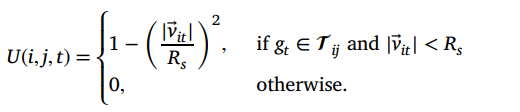

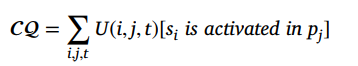

In [ ]:
def coverage_quality(mask, network):
  sensors = network['sensors']
  targets = network['targets']
  radius = network['radius']
  n = network['n']
  m = network['m']
  q = network['q']
  T = np.zeros((n, q, m), dtype=bool)

  bisectors = []
  for i in range(q):
      bisectors.append((radius*np.cos(np.pi*(1 + i*2)/q), radius*np.sin(np.pi*(1 + i*2)/q)))

  for i in range(n):
      for j in range(m):
          for p in range(q):
              T[i, p, j] = is_within_FoV(bisectors[p], targets[j], sensors[i], radius)

  U = np.zeros((n, q, m), dtype=float)
  for i in range(n):
    for j in range(m):
        for p in range(q):
          if T[i, p, j]:
            target = np.asarray(targets[j])
            sensor = np.asarray(sensors[i])
            v = target - sensor
            U[i, p, j] = 1 - np.square(np.linalg.norm(v)/radius)

  S = np.zeros((n, q), dtype=bool)
  for i in range(n):
    if mask[i] != q:
      S[i, mask[i]] = True

  return np.sum(np.sum(U, axis=2)*S)


# Presentation

## Result

In [ ]:
history = result['history']

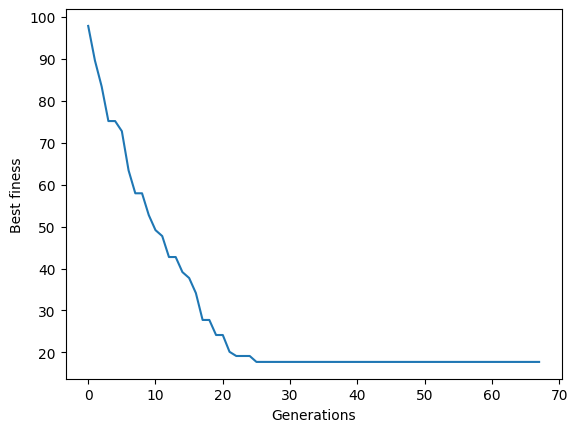

In [ ]:
plt.plot(np.arange(len(history)), history)
plt.xlabel("Generations")
plt.ylabel("Best finess")

plt.show()

In [ ]:
coverage_quality(best_result.genome, network)

NameError: ignored

In [ ]:
print("Overall best finess:", history[-1])

Overall best finess: 17.74032184970986


## Cooldown

In [ ]:
# call cooldown(temperature)

y_r = [1000]
for i in range(500):
  y_r.append(cooldown(y_r[-1]))

y_r = np.asarray(y_r)
x_r = np.arange(y_r.shape[0])

Text(0, 0.5, 'Temperature')

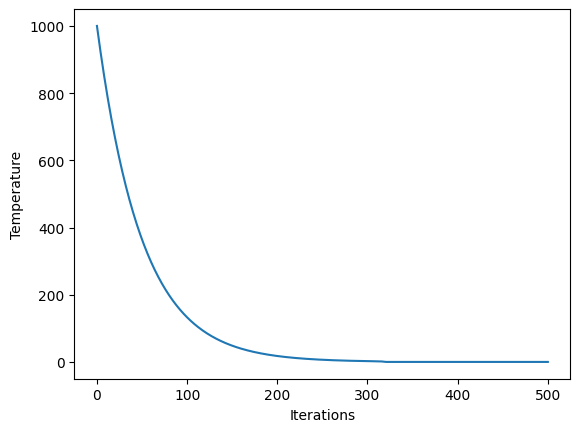

In [ ]:
plt.plot(x_r, y_r)
plt.xlabel("Iterations")
plt.ylabel("Temperature")

In [ ]:
y_r[250]

6.404996888794918

# Evaluate

## Make evaluate dataset

## Fixed sensors

In [ ]:
model_fs = GAModel()

### Distance index

In [ ]:
DI_fs_small = []
VAR_fs_small = []
CQ_fs_small = []
for i in range(10):
  di = []
  var = []
  cq = []
  for dt in tqdm.tqdm(fs_data[i]['small']):
    model_fs.adapt(dt)
    config_fs = Config(pop_size=max(50, int(dt['n']*dt['q'])), temperature=1000, threshold=.7, useless_penalty=1., active_penalty=1./(dt['n'] + 1))
    model_fs.compile(config_fs)
    result = model_fs.solve(verbose=0)

    DI_score = distance_index(np.asarray(dt['K']), result['result'].achieved_coverage)
    var_score = variance(np.asarray(dt['K']), result['result'].achieved_coverage)
    cq_score = coverage_quality(result['result'].genome, dt)

    di.append(DI_score)
    var.append(var_score)
    cq.append(cq_score)
  DI_fs_small.append(di)
  VAR_fs_small.append(var)
  CQ_fs_small.append(cq)


100%|██████████| 118/118 [04:53<00:00,  2.49s/it]


In [ ]:
DI_fs_avg = np.mean(DI_fs_small, axis=0)
VAR_fs_avg = np.mean(VAR_fs_small, axis=0)
CQ_fs_avg = np.mean(CQ_fs_small, axis=0)

In [ ]:
with open('/content/di_ga_fs.npy', 'wb') as f:
  np.save(f, DI_fs_avg)

In [ ]:
with open('/content/var_ga_fs.npy', 'wb') as f:
  np.save(f, VAR_fs_avg)

In [ ]:
with open('/content/cq_ga_fs.npy', 'wb') as f:
  np.save(f, CQ_fs_avg)

In [ ]:
act_fs_small = []
for i in range(10):
  act = []
  for dt in tqdm.tqdm(fs_data[i]['small']):
    model_fs.adapt(dt)
    config_fs = Config(pop_size=max(50, int(dt['n']*dt['q'])), temperature=1000, threshold=.7, useless_penalty=1., active_penalty=1./(dt['n'] + 1))
    model_fs.compile(config_fs)
    result = model_fs.solve(verbose=0)

    act_score = activated_sensors(result['result'].genome, 8)

    act.append(act_score)

  act_fs_small.append(act)


100%|██████████| 118/118 [04:43<00:00,  2.41s/it]


In [ ]:
act_fs_avg = np.mean(act_fs_small, axis=0)

In [ ]:
with open('/content/act_ga_fs.npy', 'wb') as f:
  np.save(f, act_fs_avg)

# Fix target

In [ ]:
model_ft = GAModel()

In [ ]:
index = range(0, 118, 3)

In [ ]:
DI_ft_small = []
ACT_ft_small = []
CQ_ft_small = []
for i in range(10):
  di = []
  act = []
  cq = []
  for id in tqdm.tqdm(index):
    dt = ft_data[i]['small'][id]
    model_ft.adapt(dt)
    config_ft = Config(pop_size=max(50, int(dt['n']*dt['q'])), temperature=1000, threshold=.7, useless_penalty=1., active_penalty=1./(dt['n'] + 1))
    model_ft.compile(config_ft)
    result = model_ft.solve(verbose=0)

    DI_score = distance_index(np.asarray(dt['K']), result['result'].achieved_coverage)
    # var_score = variance(np.asarray(dt['K']), result['result'].achieved_coverage)
    act_score = activated_sensors(result['result'].genome, 8)
    cq_score = coverage_quality(result['result'].genome, dt)

    di.append(DI_score)
    act.append(act_score)
    cq.append(cq_score)
  DI_ft_small.append(di)
  ACT_ft_small.append(act)
  CQ_ft_small.append(cq)

 48%|████▊     | 19/40 [00:52<00:58,  2.79s/it]


KeyboardInterrupt: ignored

In [ ]:
DI_ft_avg = np.mean(DI_ft_small, axis=0)
ACT_ft_avg = np.mean(ACT_ft_small, axis=0)
CQ_ft_avg = np.mean(CQ_ft_small, axis=0)

In [ ]:
with open('/content/di_ga_ft.npy', 'wb') as f:
  np.save(f, DI_ft_avg)

with open('/content/act_ga_ft.npy', 'wb') as f:
  np.save(f, ACT_ft_avg)

with open('/content/cq_ga_ft.npy', 'wb') as f:
  np.save(f, CQ_ft_avg)

In [ ]:
# di_fs
!gdown 1rtJqFAlDgeQ0mgavwsFLBJlSm0MR9YSF
# var_fs
!gdown 1wWcOtHbITeg5Bzi1Ck5ZhUhFA3xK2h1G
# cq_fs
!gdown 12FBQPOlkaCwU6uOhXFTVzPQxezssiea0

Downloading...
From: https://drive.google.com/uc?id=1rtJqFAlDgeQ0mgavwsFLBJlSm0MR9YSF
To: /content/Distance_Index_fs.csv
100% 7.12k/7.12k [00:00<00:00, 15.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wWcOtHbITeg5Bzi1Ck5ZhUhFA3xK2h1G
To: /content/Variance_fs.csv
100% 6.92k/6.92k [00:00<00:00, 23.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=12FBQPOlkaCwU6uOhXFTVzPQxezssiea0
To: /content/CQ_fs.csv
100% 6.91k/6.91k [00:00<00:00, 17.9MB/s]


In [ ]:
import pandas as pd

In [ ]:
di_fs = pd.read_csv('/content/Distance_Index_fs.csv')
var_ds = pd.read_csv('/content/Variance_fs.csv')
cq_fs = pd.read_csv('/content/CQ_fs.csv')

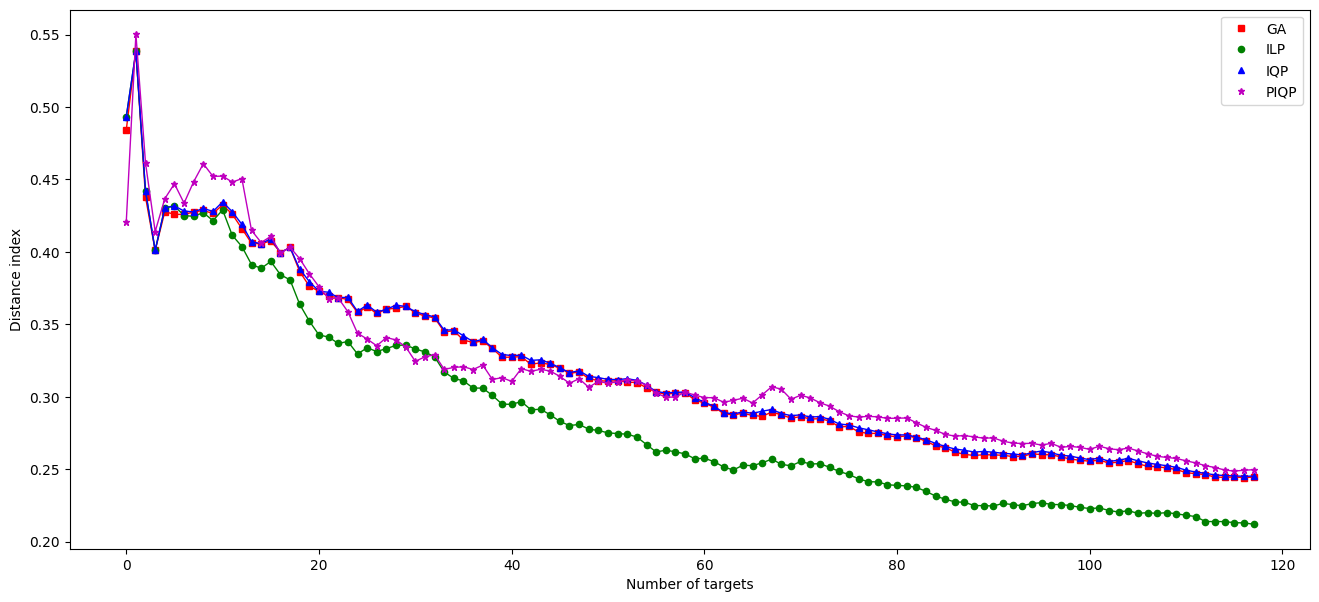

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(DI_fs_avg))
plt.plot(x_axis, DI_fs_avg, 'r-', linewidth=1.0)
plt.plot(x_axis, DI_fs_avg, 'rs', markersize=4.5, label='GA')

plt.plot(x_axis, di_fs['ILP'], 'g-', linewidth=1.0)
plt.plot(x_axis, di_fs['ILP'], 'go', markersize=4.5, label='ILP')

plt.plot(x_axis, di_fs['IQP'], 'b-', linewidth=1.0)
plt.plot(x_axis, di_fs['IQP'], 'b^', markersize=4.5, label='IQP')

plt.plot(x_axis, di_fs['PIQP'], 'm-', linewidth=1.0)
plt.plot(x_axis, di_fs['PIQP'], 'm*', markersize=4.5, label='PIQP')

plt.xlabel("Number of targets")
plt.ylabel("Distance index")
plt.legend()
plt.show()

### Variance

In [ ]:
VARs_fs_small = []
for dt in tqdm.tqdm(small_fs):
  model_fs.adapt(dt)
  config_fs = Config(pop_size=max(20, int(dt['n']*dt['q']*0.5)), temperature=1000, threshold=.7, useless_penalty=1.2, active_penalty=0.001)
  model_fs.compile(config_fs)
  result = model_fs.solve(verbose=0)
  var_score = variance(np.asarray(dt['K']), result['result'].achieved_coverage)
  VARs_fs_small.append(var_score)

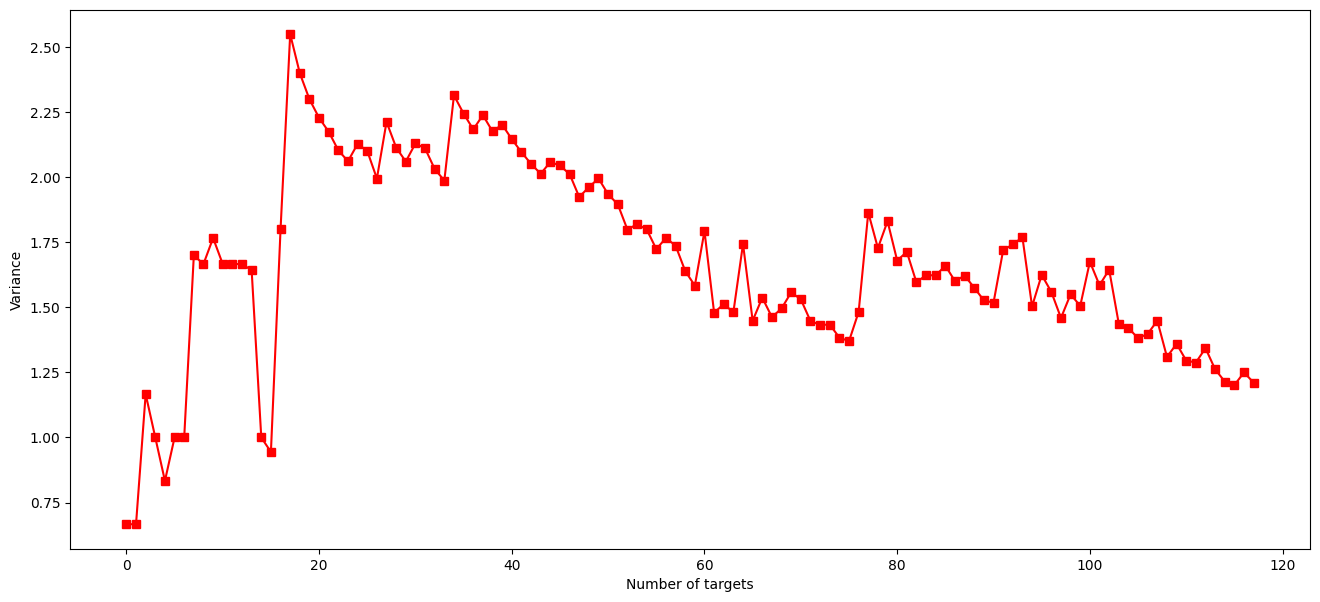

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(small_fs))
plt.plot(x_axis, VARs_fs_small, 'r-')
plt.plot(x_axis, VARs_fs_small, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Variance")
plt.show()

## Fixed target


In [ ]:
small_ft = eval_data['fixed-target']['small']

In [ ]:
model_ft = GAModel()

### Active sensors

In [ ]:
ACT_ft_small = []
for dt in tqdm.tqdm(small_ft):
  model_ft.adapt(dt)
  config_ft = Config(pop_size=max(20, int(dt['n']*dt['q'])), temperature=1000, threshold=.7, useless_penalty=1.2, active_penalty=0.001)
  model_ft.compile(config_ft)
  result = model_ft.solve(verbose=0)
  act_score = activated_sensors(result['results'][0].genome, 8)
  ACT_ft_small.append(act_score)

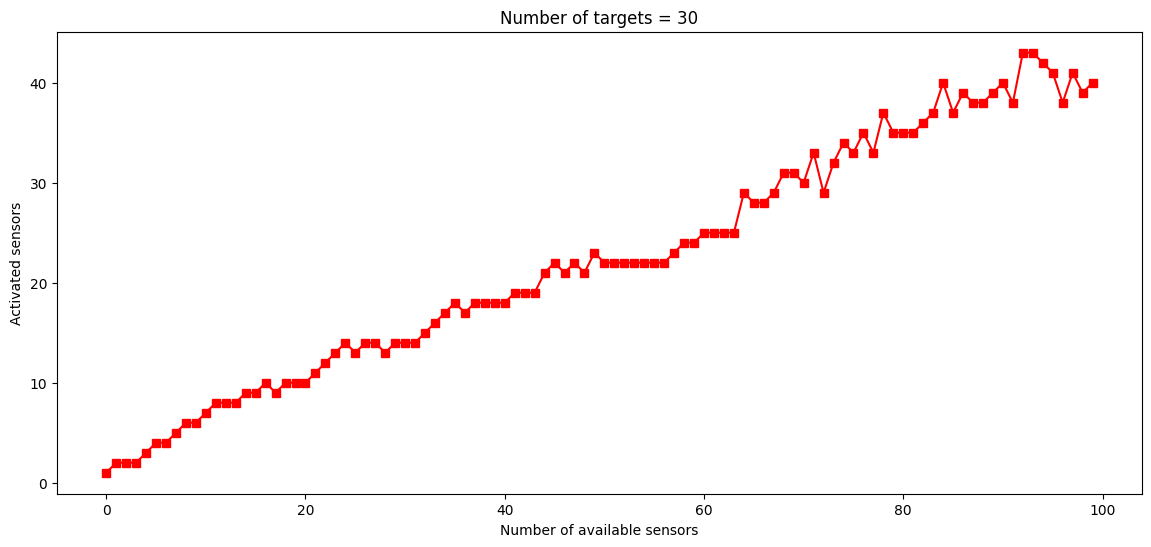

In [ ]:
plt.figure(figsize=(14, 6))
x_axis = np.arange(len(ACT_ft_small))
plt.plot(x_axis, ACT_ft_small, 'r-')
plt.plot(x_axis, ACT_ft_small, 'rs')
plt.xlabel("Number of available sensors")
plt.ylabel("Activated sensors")
plt.title(f'Number of targets = {small_ft[0]["m"]}')
plt.show()

### Coverage Quality

In [ ]:
CQ_ft_small = []
for dt in tqdm.tqdm(small_ft):
  model_ft.adapt(dt)
  config_ft = Config(pop_size=max(40, int(dt['n']*dt['q']*0.5)), temperature=1000, threshold=.7, useless_penalty=5.0, active_penalty=0.001)
  model_ft.compile(config_ft)
  result = model_ft.solve(verbose=0)
  cq_score = coverage_quality(result['result'].genome, dt)
  CQ_ft_small.append(cq_score)

100%|██████████| 118/118 [14:26<00:00,  7.35s/it]


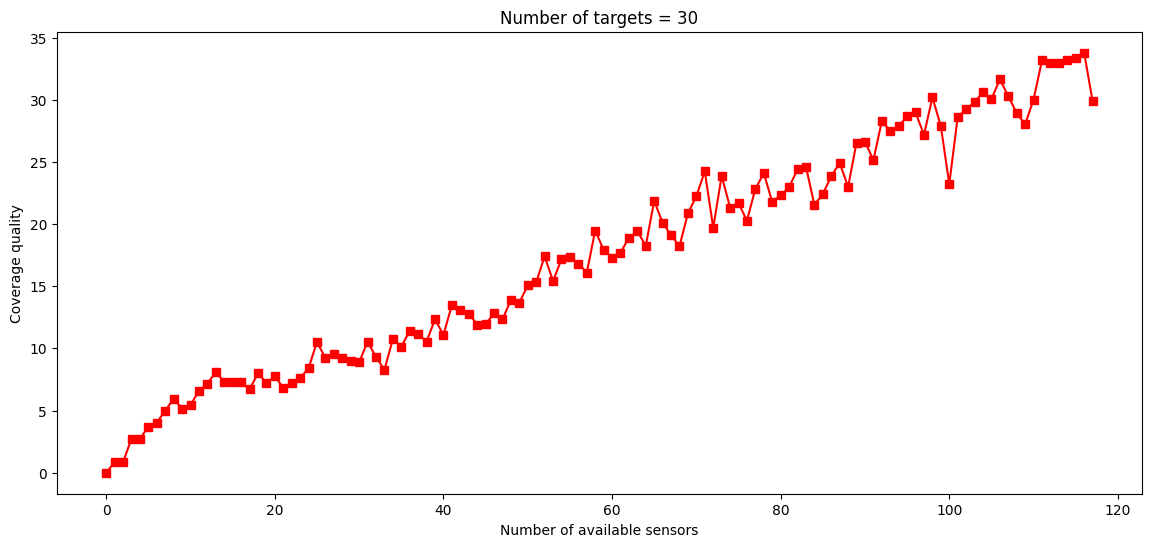

In [ ]:
plt.figure(figsize=(14, 6))
x_axis = np.arange(len(CQ_ft_small))
plt.plot(x_axis, CQ_ft_small, 'r-')
plt.plot(x_axis, CQ_ft_small, 'rs')
plt.xlabel("Number of available sensors")
plt.ylabel("Coverage quality")
plt.title(f'Number of targets = {small_ft[0]["m"]}')
plt.show()

___


# _____

In [ ]:
test_data = small_ft[80]

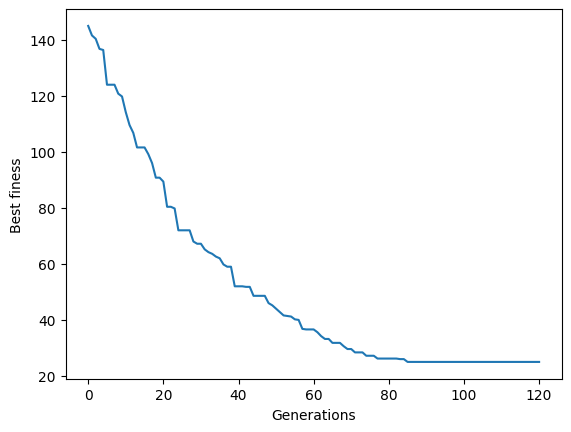

In [ ]:
history = result['history']

plt.plot(np.arange(len(history)), history)
plt.xlabel("Generations")
plt.ylabel("Best finess")

plt.show()

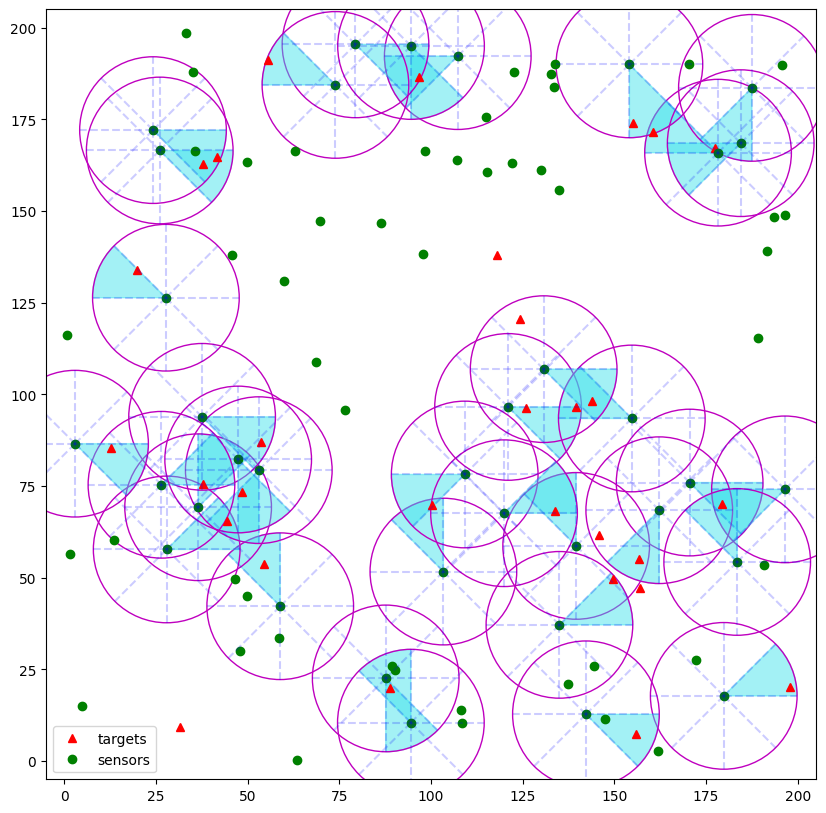

In [ ]:
show_network(test_data, result['results'][0].genome, figsize=10)

___

# To do:



In [ ]:
#@title Boolean fields
PSO = True #@param {type:"boolean"}
DE = False #@param {type:"boolean"}
Set seed = True #@param {type:"boolean"}
Save dataset = True #@param {type:"boolean"}


True
True
